# Notebook for enriching protein-bioloical process and drug-biological process edges

In [1]:
import pandas as pd
from tqdm import tqdm

from matplotlib_venn import venn2_unweighted
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Load KG files

In [2]:
KG_DIR = '../data/kg/'

In [3]:
openbiolink_df = pd.read_csv(f'{KG_DIR}/openbiolink_filtered.tsv', sep='\t')
openbiolink_df.head(2)

,source,target,polarity
0,pubchem.compound:10607,ncbigene:3553,1
1,pubchem.compound:10607,ncbigene:203068,-1


In [4]:
custom_df = pd.read_csv(f'{KG_DIR}/customkg_filtered.tsv', sep='\t')
custom_df.head(2)

,source,target,polarity
0,pubchem.compound:4943,ncbigene:2562,1
1,pubchem.compound:4943,ncbigene:2563,1


# Subset to proteins for process enrichments

In [5]:
openbiolink_proteins = set()

for source, target, rel in tqdm(openbiolink_df.values):
    if 'ncbigene' in source:
        openbiolink_proteins.add(source)

    if 'ncbigene' in target:
        openbiolink_proteins.add(target)

len(openbiolink_proteins)

100%|██████████| 41441/41441 [00:00<00:00, 144844.86it/s]


4618

In [6]:
custom_proteins = set()

for source, target, rel in tqdm(custom_df.values):
    if 'ncbigene' in source:
        custom_proteins.add(source)

    if 'ncbigene' in target:
        custom_proteins.add(target)

len(custom_proteins)


100%|██████████| 51400/51400 [00:00<00:00, 373582.26it/s]


8229

# Map the protein to their GO annotations

In [7]:
MAPPING_DIR = '../data/mappings'

In [8]:
process_df = pd.read_csv(
    f'{MAPPING_DIR}/gene2go.tsv', sep='\t', dtype=str,
)

process_df = process_df[process_df['#tax_id'] == '9606']
process_df.head(2)

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812115,9606,1,GO:0003674,ND,enables,molecular_function,-,Function
812116,9606,1,GO:0005576,HDA,located_in,extracellular region,27068509,Component


In [9]:
process_df.Category.value_counts()

Process      157388
Component    103600
Function      84844
Name: Category, dtype: int64

In [10]:
process_df['GeneID'] = 'ncbigene:' + process_df['GeneID']

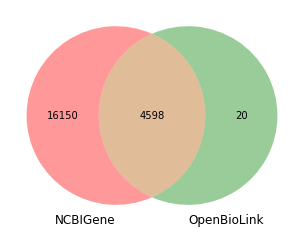

In [11]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), openbiolink_proteins],
    set_labels=['NCBIGene', 'OpenBioLink']
)

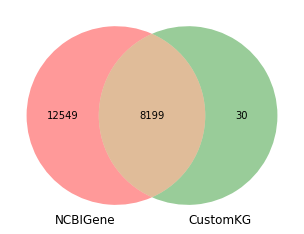

In [12]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), custom_proteins],
    set_labels=['NCBIGene', 'CustomKG']
)

# GO Functions

In [13]:
custom_proteins.update(openbiolink_proteins)
prots_of_interest = set(process_df['GeneID'].unique()).intersection(custom_proteins)
len(prots_of_interest)

9254

In [14]:
filtered_df = process_df[process_df['GeneID'].isin(prots_of_interest)]
filtered_df.to_csv('../data/mappings/in_kg_go_terms.tsv', sep='\t', index=False)

In [15]:
genes = set()
function_keywords = {}
process_keywords = {}
component_keywords = {}

for tax_id, gene_id, go_id, ref, rel, term, pid, category  in tqdm(process_df.values):
    if category == 'Process':
        if gene_id not in process_keywords:
            process_keywords[gene_id] = set()
        process_keywords[gene_id].add(term)
        genes.add(gene_id)

    if category == 'Function':
        if gene_id not in function_keywords:
            function_keywords[gene_id] = set()   
        function_keywords[gene_id].add(term)
        genes.add(gene_id)
    
    if category == 'Component':
        if gene_id not in component_keywords:
            component_keywords[gene_id] = set() 
        component_keywords[gene_id].add(term)
        genes.add(gene_id)
        
len(function_keywords), len(process_keywords), len(component_keywords), len(genes)

100%|██████████| 345832/345832 [00:01<00:00, 315438.88it/s]


(18495, 18903, 19866, 20748)

In [16]:
custom_proteins.update(openbiolink_proteins)

In [17]:
kg_nodes_with_process = 0
kg_nodes_with_function = 0
kg_nodes_with_comp = 0

kg_nodes_without = 0

number_of_process = []
number_of_compartments = []
number_of_functions = []

p_words = []
c_words = []
f_words = []

for node in tqdm(custom_proteins):
    
    if node not in genes:
        kg_nodes_without += 1
    else:
        if node in process_keywords:
            kg_nodes_with_process += 1
            number_of_process.append(len(process_keywords[node]))
            
            # For the ones with multiple keywords, see what they are
            if len(process_keywords[node]) > 1:
                for keyword in process_keywords[node]:
                    p_words.append(keyword)

        if node in component_keywords:
            kg_nodes_with_comp += 1
            number_of_compartments.append(len(component_keywords[node]))

            # For the ones with multiple keywords, see what they are
            if len(component_keywords[node]) > 1:
                for keyword in component_keywords[node]:
                    c_words.append(keyword)

        if node in function_keywords:
            kg_nodes_with_function += 1
            number_of_functions.append(len(function_keywords[node]))
            # For the ones with multiple keywords, see what they are
            if len(function_keywords[node]) > 1:
                for keyword in function_keywords[node]:
                    f_words.append(keyword)

kg_nodes_without, kg_nodes_with_process, kg_nodes_with_comp, kg_nodes_with_function

100%|██████████| 9301/9301 [00:00<00:00, 46796.08it/s]


(47, 9142, 9195, 9122)

# Looking into most commons

In [18]:
Counter(c_words).most_common()

[('cytosol', 3379),
 ('nucleus', 2761),
 ('cytoplasm', 2670),
 ('plasma membrane', 2665),
 ('nucleoplasm', 2393),
 ('membrane', 1702),
 ('extracellular exosome', 1470),
 ('extracellular region', 1063),
 ('extracellular space', 1035),
 ('mitochondrion', 764),
 ('endoplasmic reticulum', 627),
 ('endoplasmic reticulum membrane', 585),
 ('Golgi apparatus', 579),
 ('chromatin', 563),
 ('intracellular membrane-bounded organelle', 539),
 ('nucleolus', 514),
 ('perinuclear region of cytoplasm', 476),
 ('cell surface', 469),
 ('protein-containing complex', 445),
 ('Golgi membrane', 390),
 ('focal adhesion', 319),
 ('synapse', 308),
 ('centrosome', 301),
 ('dendrite', 299),
 ('glutamatergic synapse', 294),
 ('external side of plasma membrane', 278),
 ('neuronal cell body', 272),
 ('neuron projection', 249),
 ('apical plasma membrane', 247),
 ('nuclear speck', 246),
 ('collagen-containing extracellular matrix', 245),
 ('endoplasmic reticulum lumen', 244),
 ('mitochondrial matrix', 234),
 ('mitoch

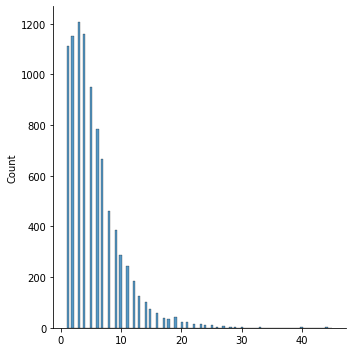

In [19]:
sns.displot(number_of_compartments)

In [20]:
Counter(p_words).most_common()

[('signal transduction', 800),
 ('positive regulation of transcription by RNA polymerase II', 795),
 ('regulation of transcription by RNA polymerase II', 749),
 ('G protein-coupled receptor signaling pathway', 747),
 ('negative regulation of transcription by RNA polymerase II', 542),
 ('positive regulation of DNA-templated transcription', 484),
 ('regulation of DNA-templated transcription', 404),
 ('detection of chemical stimulus involved in sensory perception of smell',
  404),
 ('apoptotic process', 397),
 ('protein phosphorylation', 396),
 ('positive regulation of gene expression', 376),
 ('positive regulation of cell population proliferation', 371),
 ('negative regulation of apoptotic process', 354),
 ('inflammatory response', 336),
 ('negative regulation of DNA-templated transcription', 331),
 ('negative regulation of cell population proliferation', 318),
 ('cell differentiation', 285),
 ('innate immune response', 277),
 ('intracellular signal transduction', 261),
 ('cell adhesion

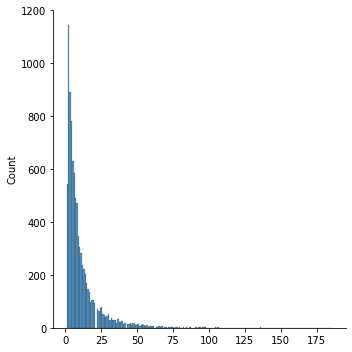

In [21]:
sns.displot(number_of_process)

In [22]:
Counter(f_words).most_common()

[('protein binding', 6350),
 ('metal ion binding', 1267),
 ('ATP binding', 1028),
 ('identical protein binding', 1018),
 ('RNA binding', 785),
 ('RNA polymerase II cis-regulatory region sequence-specific DNA binding',
  659),
 ('DNA-binding transcription factor activity, RNA polymerase II-specific',
  616),
 ('DNA binding', 575),
 ('G protein-coupled receptor activity', 553),
 ('protein homodimerization activity', 500),
 ('zinc ion binding', 418),
 ('olfactory receptor activity', 403),
 ('protein kinase binding', 343),
 ('calcium ion binding', 330),
 ('sequence-specific double-stranded DNA binding', 296),
 ('DNA-binding transcription activator activity, RNA polymerase II-specific',
  293),
 ('enzyme binding', 278),
 ('DNA-binding transcription factor activity', 271),
 ('chromatin binding', 266),
 ('protein-containing complex binding', 261),
 ('signaling receptor binding', 256),
 ('protein serine kinase activity', 249),
 ('ubiquitin protein ligase binding', 246),
 ('protein serine/threo

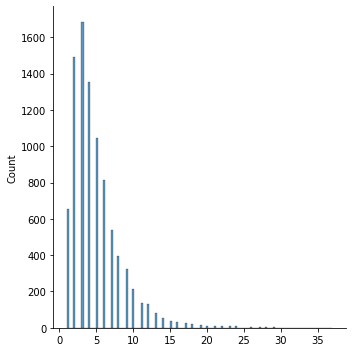

In [23]:
sns.displot(number_of_functions)